In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(365)
from numpy import mean
import pickle
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX 



### Read in Datasets for all boroughs

In [2]:
all_df = pickle.load(open('./data/final_cleaned_data/all_cleaned_data.pkl','rb'))
bronx_df = pickle.load(open('./data/final_cleaned_data/bronx_cleaned_data.pkl','rb'))
brooklyn_df = pickle.load(open('./data/final_cleaned_data/brooklyn_cleaned_data.pkl','rb'))
manhattan_df = pickle.load(open('./data/final_cleaned_data/manhattan_cleaned_data.pkl','rb'))
queens_df = pickle.load(open('./data/final_cleaned_data/queens_cleaned_data.pkl','rb'))
staten_df = pickle.load(open('./data/final_cleaned_data/staten_cleaned_data.pkl','rb'))

##### we will use up to 2020-03-21 the day before lockdown started

In [3]:
# Manhattan 
man_precovid_df = manhattan_df[:'2020-03-21']
#man_covid_df = manhattan_df['2020-03-22':]

#Queens
queens_precovid_df = queens_df[:'2020-03-21']
#queens_covid_df = queens_df['2020-03-22':]

# Brooklyn
brooklyn_precovid_df = brooklyn_df[:'2020-03-21']
#brooklyn_covid_df = brooklyn_df['2020-03-22':]

# Bronx
bronx_precovid_df = bronx_df[:'2020-03-21']
#bronx_covid_df = bronx_df['2020-03-22':]

# Staten Island
staten_precovid_df = staten_df[:'2020-03-21']
#staten_covid_df = staten_df['2020-03-22':]

## Train Test Split our data. We will use 2019-06-01 to 2020-01-31 as our Train set and 2020-02-01 to 2020-03-21 as our test set 

In [4]:
## PRECOVID TRAIN(70%), TEST SET(30%)
#X = man_precovid_df.values
#size = int(len(X) * 0.70)
size='2020-01-31'
man_precovid_train, man_precovid_test  = man_precovid_df[:size], man_precovid_df[size:]
queens_precovid_train, queens_precovid_test  = queens_precovid_df[:size], queens_precovid_df[size:]
brooklyn_precovid_train, brooklyn_precovid_test  = brooklyn_precovid_df[:size], brooklyn_precovid_df[size:]
bronx_precovid_train, bronx_precovid_test  = bronx_precovid_df[:size], bronx_precovid_df[size:]
staten_precovid_train, staten_precovid_test  = staten_precovid_df[:size], staten_precovid_df[size:]

#covid='2020-05-31'
#lockdown='2020-03-22'
#man_covid_train, man_covid_test = man_covid_df[lockdown:covid], man_covid_df['2020-06-01':]
#queens_covid_train, queens_covid_test = queens_covid_df[lockdown:covid], queens_covid_df['2020-06-01':]
#brooklyn_covid_train, brooklyn_covid_test = brooklyn_covid_df[lockdown:covid], brooklyn_covid_df['2020-06-01':]
#bronx_covid_train, bronx_covid_test = bronx_covid_df[lockdown:covid], bronx_covid_df['2020-06-01':]
#staten_covid_train, staten_covid_test = staten_covid_df[lockdown:covid], staten_covid_df['2020-06-01':]

In [5]:
queens_precovid_train

,count
pickup_time,
2019-06-01 00:00:00,724
2019-06-01 01:00:00,481
2019-06-01 02:00:00,206
2019-06-01 03:00:00,106
2019-06-01 04:00:00,164
...,...
2020-01-31 19:00:00,739
2020-01-31 20:00:00,743
2020-01-31 21:00:00,728


### placeholder for the RMSE scores: I will bring the results from 03.Baseline_Models_precovid.ipynb

In [6]:
placeholder_man = pickle.load(open('./data/pickled/placeholder_manhattan.pkl','rb'))
placeholder_queens = pickle.load(open('./data/pickled/placeholder_queens.pkl','rb'))
placeholder_brooklyn = pickle.load(open('./data/pickled/placeholder_brooklyn.pkl','rb'))
placeholder_bronx = pickle.load(open('./data/pickled/placeholder_bronx.pkl','rb'))
placeholder_staten = pickle.load(open('./data/pickled/placeholder_staten.pkl','rb'))
placeholder_man

{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2036.5722509949862,
 'rmse_holt_winter': 987.1542055166258}

# Manhattan

## PRE-COVID:

### Dickey-Fuller Test to check if our data is stationay for Manhattan:

In [7]:
## CHECK TO SEE IF OUR DATA IS STATINONARY
ad_test = adfuller(man_precovid_train['count'])
print('ADF Statistic: %f' % ad_test[0])
print('p-value: %f' % ad_test[1])
print('Critical Values:')
for key, value in ad_test[4].items():
    print('\t%s: %.3f' % (key, value))
print('number of observations used:', ad_test[3])
print('lags used:', ad_test[2])

ADF Statistic: -7.478913
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
number of observations used: 5845
lags used: 34


We can see here that our p-value is less than our alpha value and also test statistic is less than the critical value, so we can reject the null hypothesis. (null hypothesis is the data is not stationary). So our data is stationary. We do not need to difference our data.

## ACF AND PACF

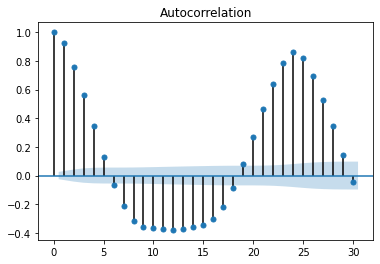

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(man_precovid_train['count'], alpha=.05, lags=30);

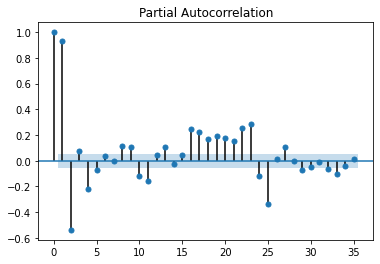

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(man_precovid_test['count'], alpha=.05, lags=35);

#### ARIMA #1:

In [10]:
model = ARIMA(man_precovid_train, order=(3,0,2)) 
arima_1 = model.fit(disp=0)
print(arima_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                 5880
Model:                     ARMA(3, 2)   Log Likelihood              -49798.001
Method:                       css-mle   S.D. of innovations           1152.650
Date:                Thu, 12 Nov 2020   AIC                          99610.002
Time:                        08:23:40   BIC                          99656.757
Sample:                    06-01-2019   HQIC                         99626.255
                         - 01-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8210.1752     79.875    102.788      0.000    8053.623    8366.727
ar.L1.count     1.8621      0.032     58.584      0.000       1.800       1.924
ar.L2.count    -1.0095      0.054    -18.723    

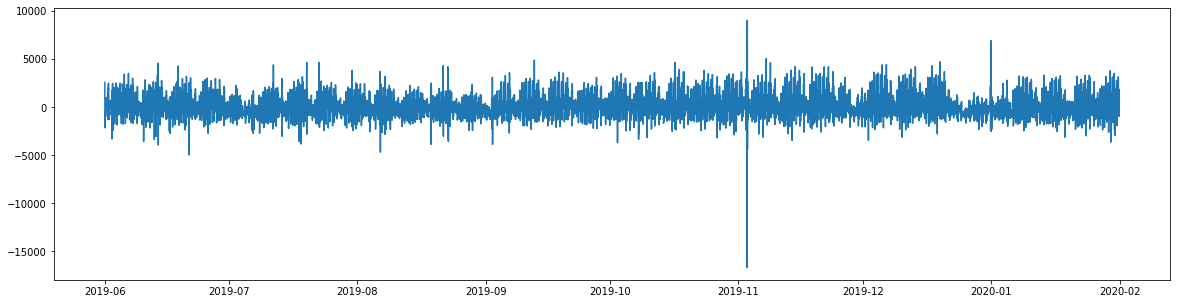

,0
count,5880.000000
mean,0.142977
std,1153.361969
min,-16673.410072
25%,-675.088495
50%,-135.627580
75%,525.775944
max,8977.406747


In [11]:
plt.figure(figsize=(20,5))  # plot the residuals

residuals = pd.DataFrame(arima_1.resid)
plt.plot(residuals)
plt.show()
residuals.describe()

mean of residual is close to 0. There may not be any bias in our model

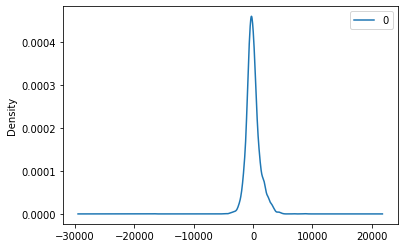

In [12]:
residuals = pd.DataFrame(arima_1.resid)  # plot the residuals distribution
residuals.plot(kind='kde',)
plt.show()

In [13]:
# evaluate the model on the training data
train_arma_rmse = np.sqrt(np.mean(arima_1.resid**2))  # check the RMSE scores
placeholder_man['arima_1'] = train_arma_rmse

placeholder_man

{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2036.5722509949862,
 'rmse_holt_winter': 987.1542055166258,
 'arima_1': 1153.263898456226}

Our pre-lockdown data shows that we did not do as well as Holt Winter's Exponential smoothing model but still did alot better than our baseline model. We will try to improve on this.

In [14]:
# get predictions for the test data
predictions = arima_1.predict(start=man_precovid_test.index[0], end=man_precovid_test.index[-1])
residuals = man_precovid_test['count'] - predictions  # get the residuals
test_arma_rmse = np.sqrt(np.mean(residuals**2))
print(test_arma_rmse)

4724.1683018671465


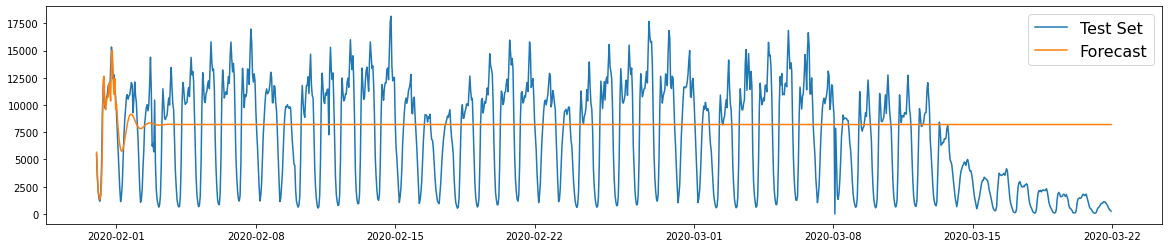

In [15]:
plt.figure(figsize=(20,4))  # plot the predictions and the actual data

plt.plot(man_precovid_test)
plt.plot(predictions)

plt.legend(('Test Set', 'Forecast'), fontsize=16)

After few days, our prediction is flat and seem like we are forecasting at a constant level. We will see if we can improve this with another model to see if we can cast better predictions.

## ARIMA 2

In [16]:
model_2 = SARIMAX(man_precovid_df['count'], order = (3, 0, 2)) 
  
result = model_2.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  count   No. Observations:                 7080
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -60705.166
Date:                Thu, 12 Nov 2020   AIC                         121422.332
Time:                        08:24:18   BIC                         121463.523
Sample:                    06-01-2019   HQIC                        121436.518
                         - 03-21-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5847      0.082      7.110      0.000       0.424       0.746
ar.L2          0.5547      0.117      4.735      0.000       0.325       0.784
ar.L3         -0.1916      0.041     -4.649      0.000      -0.272      -0.111
ma.L1          1.1453      0.083     13.816      0.000       0.983       1.308
ma.L2          0.3624      0.031     11.831      0.000       0.302       0.422
sigma2      1.619e+06   1.41e+04    114.462      0.000    1.59e+06    1.65e+06
===================================================================================
Ljung-Box (Q):                     5200.74   Jarque-Bera (JB):             42608.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'Forecasting from June 2019 to  March 2020(Before Covid Lockdown)')

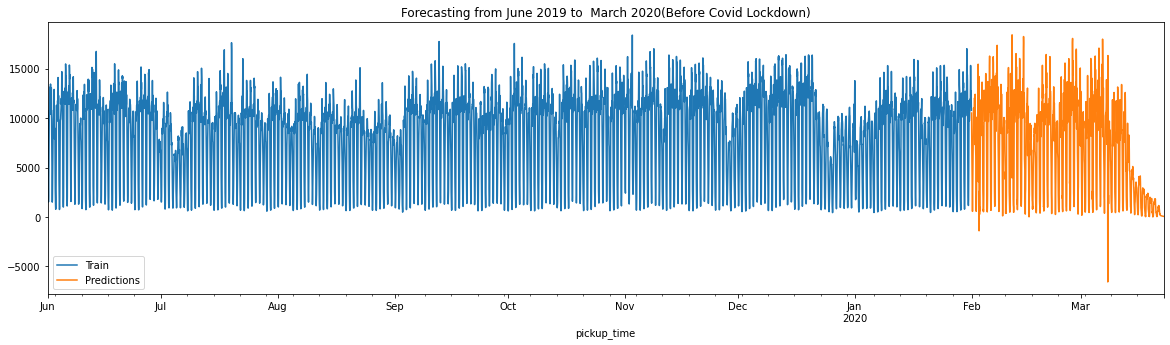

In [17]:
start = len(man_precovid_train) 
end = len(man_precovid_train) + len(man_precovid_test) - 1
  
# Predictions for one-month against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
fig, ax = plt.subplots(figsize=(20, 5))
man_precovid_train.plot(legend=True, ax=ax)
predictions.plot(legend = True, ax=ax) 
#man_covid_test['count'].plot(legend = True, ax=ax)
plt.legend(['Train', 'Predictions'])
plt.title('Forecasting from June 2019 to  March 2020(Before Covid Lockdown)')

Text(0.5, 1.0, 'Forecasting from December 24th to March 21st (before Covid Lockdown)')

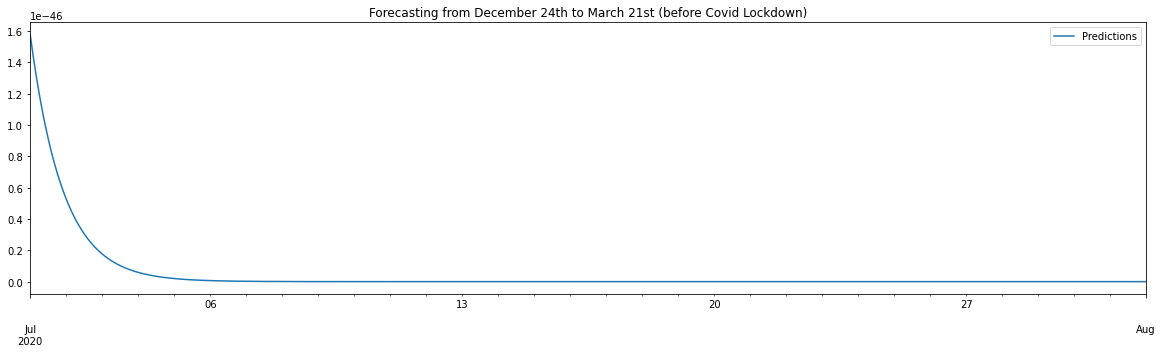

In [18]:
#start = len(man_covid_train) 
#end = len(man_covid_train) + len(man_covid_test) - 1
  
# Predictions for one-month against the test set 
june_predictions = result.predict('2020-07-01', '2020-08-01', 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
fig, ax = plt.subplots(figsize=(20, 5))
june_predictions.plot(legend = True) 
#man_covid_test['count'].plot(legend = True) 
plt.title('Forecasting from December 24th to March 21st (before Covid Lockdown)')

In [19]:
# Calculate root mean squared error 
print('RMSE for ARIMA#2:' ,rmse(man_precovid_test["count"], predictions))

placeholder_man['arima_2'] = rmse(man_precovid_test["count"], predictions) 
placeholder_man

RMSE for ARIMA#2: 2654.5283587292543


{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2036.5722509949862,
 'rmse_holt_winter': 987.1542055166258,
 'arima_1': 1153.263898456226,
 'arima_2': 2654.5283587292543}

That was alot worse than our first arima model Where it seems like the demand decreases to almost 0 from July. This model is not appropriate and will need to improve.  

### Forecasting using ARIMA model

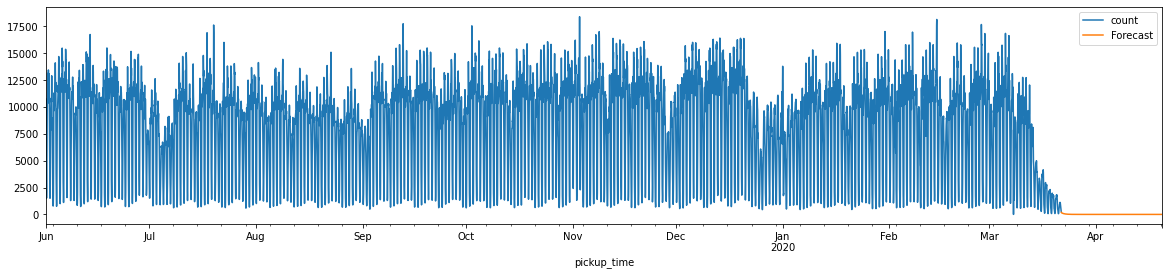

In [20]:
# Train the model on the full dataset 
model = SARIMAX(man_precovid_df['count'],  order = (2, 0, 1)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(man_precovid_df),  
                          end = (len(man_precovid_df)) + 700,  
                          typ='levels').rename('Forecast') 
  
# Plot the forecast values 
man_precovid_df['count'].plot(figsize = (20, 4), legend = True) 
forecast.plot(legend = True) 

This model failed as my forecast after lockdown goes to 0.  I will try by seeing if adding seasonality will help get better RMSE score.

## SARIMA

Since our ARIMA model was not forecasting well, let's see how our model does with seasonal order. I put seasonality of 24 because my dataset is by hour interval

Instantiate a SARIMAX model without exogenous variable then fit the model and view the summary

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (2,0,1)
seasonal_order = (2, 0, 1, 24)

model = SARIMAX(man_precovid_train['count'], seasonal_order=seasonal_order, order=order, freq='H')
sarima_1 = model.fit()


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
sarima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                 5880
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 24)   Log Likelihood              -48526.061
Date:                            Thu, 12 Nov 2020   AIC                          97066.121
Time:                                    08:34:15   BIC                          97112.876
Sample:                                06-01-2019   HQIC                         97082.374
                                     - 01-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3540      0.014     98.115      0.000       1.327       1.381
ar.L2         -0.4857      0.017    -28.422      0.000      -0.519      -0.452
ma.L1         -0.0481      0.010     -5.026      0.000      -0.067      -0.029
ar.S.L24       1.3396      0.016     84.065      0.000       1.308       1.371
ar.S.L48      -0.3397      0.016    -21.337      0.000      -0.371      -0.308
ma.S.L24      -0.9842      0.006   -155.751      0.000      -0.997      -0.972
sigma2      1.546e+06   8.04e-09   1.92e+14      0.000    1.55e+06    1.55e+06
===================================================================================
Ljung-Box (Q):                      976.90   Jarque-Bera (JB):            117430.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.43e+28. Standard errors may be unstable.
"""

In [24]:
man_precovid_test

,count
pickup_time,
2020-01-31 00:00:00,5470
2020-01-31 01:00:00,3223
2020-01-31 02:00:00,2077
2020-01-31 03:00:00,1347
2020-01-31 04:00:00,1163
...,...
2020-03-21 19:00:00,709
2020-03-21 20:00:00,539
2020-03-21 21:00:00,386


In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sarima_1.resid.plot()

In [ ]:
sarima_1.resid.describe()

Because the mean of the residual is a non-zero value, we can note that there may be bias in the prediction. 

In [25]:
predictions = sarima_1.predict(start='2020-06-01', end='2020-07-01')
predictions

2020-06-01 00:00:00    151.756636
2020-06-01 01:00:00    112.150757
2020-06-01 02:00:00     91.348595
2020-06-01 03:00:00     71.328150
2020-06-01 04:00:00     79.851633
                          ...    
2020-06-30 20:00:00    347.835412
2020-06-30 21:00:00    244.415761
2020-06-30 22:00:00    203.869290
2020-06-30 23:00:00    203.840309
2020-07-01 00:00:00    128.308448
Freq: H, Length: 721, dtype: float64

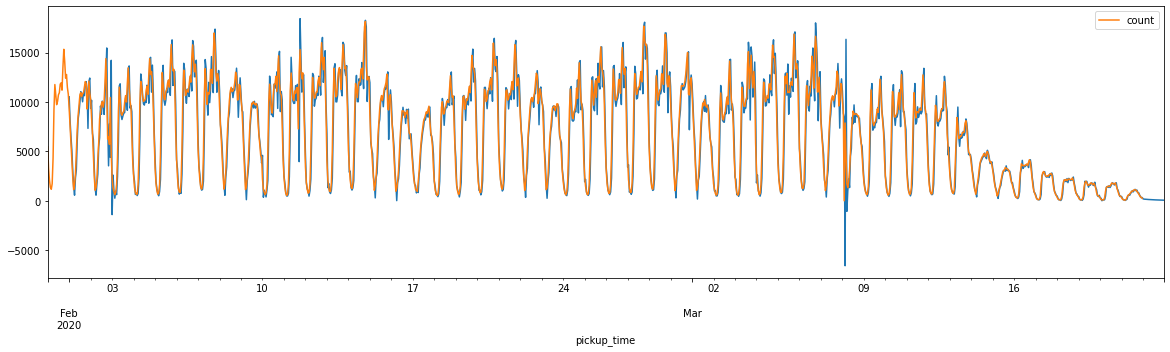

In [26]:
fig, ax = plt.subplots(figsize=(20, 5))
predictions.plot(ax=ax)
man_precovid_test.plot(ax=ax)

In [28]:
# evaluate the model on the training data
train_sarima_rmse = np.sqrt(np.mean(sarima_1.resid**2))  # check the RMSE scores
placeholder_man['sarima_1'] = train_sarima_rmse

placeholder_man

{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2036.5722509949862,
 'rmse_holt_winter': 987.1542055166258,
 'arima_1': 1153.263898456226,
 'arima_2': 2654.5283587292543,
 'sarima_1': 806.6490746187087}

This seems like my SARIMA model really perforemd well to predict on the test set! And the RMSE so far is lowest too! We will take note and see if we can forecast using this model after we run SARIMAX to see how exogenous variable can help us forecast better

#### SARMIAX

##### Adding Exogenous Variable: Date Extraction by Hour, dayofweek and month:

First exogenous variable: hour

In [29]:
# Copy the train set and index by hour
copied_train = man_precovid_train.copy()
hour = pd.DataFrame(copied_train.index.hour)
hour

,pickup_time
0,0
1,1
2,2
3,3
4,4
...,...
5875,19
5876,20
5877,21
5878,22


##### Assign hour column to train set to specify which hour the observation is at:

In [30]:

copied_train['hour'] = copied_train.index.hour
copied_train

,count,hour
pickup_time,,
2019-06-01 00:00:00,10744,0
2019-06-01 01:00:00,8371,1
2019-06-01 02:00:00,6212,2
2019-06-01 03:00:00,4319,3
2019-06-01 04:00:00,2921,4
...,...,...
2020-01-31 19:00:00,14099,19
2020-01-31 20:00:00,12407,20
2020-01-31 21:00:00,12781,21


Second Exogenous Variable: assign day of week (5 and 6 are Saturday and Sunday)

In [31]:
copied_train.index.dayofweek

Int64Index([5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='pickup_time', length=5880)

In [32]:
# assign week day and weekend
copied_train['day'] = copied_train.index.dayofweek
copied_train

,count,hour,day
pickup_time,,,
2019-06-01 00:00:00,10744,0,5
2019-06-01 01:00:00,8371,1,5
2019-06-01 02:00:00,6212,2,5
2019-06-01 03:00:00,4319,3,5
2019-06-01 04:00:00,2921,4,5
...,...,...,...
2020-01-31 19:00:00,14099,19,4
2020-01-31 20:00:00,12407,20,4
2020-01-31 21:00:00,12781,21,4


##### Now we want to dummy the data by using OneHotEncoder

In [33]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first')
ohe_fit = ohe.fit_transform(copied_train[['hour', 'day']]).toarray() ## fit transform hour and day

In [34]:
exog_df = pd.DataFrame(data=ohe_fit, index=copied_train.index, columns=ohe.get_feature_names(['hour', 'day']))
exog_df

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_20,hour_21,hour_22,hour_23,day_1,day_2,day_3,day_4,day_5,day_6
pickup_time,,,,,,,,,,,,,,,,,,,,,
2019-06-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-06-01 01:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-06-01 02:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-06-01 03:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-06-01 04:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2020-01-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2020-01-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Create SARIMAX Model:

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (2,0,2)
seasonal_order = (2, 0, 2, 24)

model = SARIMAX(copied_train['count'], exog= exog_df, seasonal_order=seasonal_order, order=order, freq='H')
sarimax_1 = model.fit()


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [36]:
sarimax_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                 5880
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood              -48969.518
Date:                            Thu, 12 Nov 2020   AIC                          98015.036
Time:                                    09:21:34   BIC                          98268.850
Sample:                                06-01-2019   HQIC                         98103.268
                                     - 01-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour_1      2341.1181   1049.837      2.230      0.026     283.475    4398.761
hour_2      1177.3230    456.554      2.579      0.010     282.493    2072.152
hour_3       246.7749     69.071      3.573      0.000     111.399     382.151
hour_4      -278.0888    188.677     -1.474      0.141    -647.889      91.711
hour_5      -128.2403    118.667     -1.081      0.280    -360.824     104.344
hour_6      2079.2034    344.597      6.034      0.000    1403.805    2754.602
hour_7      5227.8497    535.765      9.758      0.000    4177.770    6277.929
hour_8      7191.4706    833.088      8.632      0.000    5558.648    8824.293
hour_9      7504.0121    650.137     11.542      0.000    6229.766    8778.258
hour_10     7612.9184    132.114     57.624      0.000    7353.979    7871.858
hour_11     8176.7843    136.739     59.798      0.000    7908.780    8444.788
hour_12     8844.9918    134.460     65.781      0.000    8581.455    9108.529
hour_13     8887.1637    137.557     64.607      0.000    8617.557    9156.771
hour_14     9301.9883    166.882     55.740      0.000    8974.906    9629.071
hour_15     9324.7352    190.078     49.057      0.000    8952.189    9697.281
hour_16     8597.7626    434.413     19.792      0.000    7746.330    9449.196
hour_17     9998.6787    790.057     12.656      0.000    8450.196    1.15e+04
hour_18     1.128e+04    654.574     17.232      0.000    9996.602    1.26e+04
hour_19     1.057e+04    741.963     14.241      0.000    9111.849     1.2e+04
hour_20     9307.6028    702.599     13.247      0.000    7930.533    1.07e+04
hour_21     9242.2501    457.644     20.195      0.000    8345.285    1.01e+04
hour_22     8385.1679    564.809     14.846      0.000    7278.162    9492.174
hour_23     6174.0158    721.380      8.559      0.000    4760.138    7587.894
day_1       2102.2253    180.375     11.655      0.000    1748.696    2455.755
day_2       2385.6391    288.597      8.266      0.000    1820.000    2951.279
day_3       2627.7122    379.185      6.930      0.000    1884.524    3370.900
day_4       2492.4597    421.013      5.920      0.000    1667.289    3317.630
day_5       1979.2870    364.174      5.435      0.000    1265.519    2693.055
day_6        672.8380    343.820      1.957      0.050      -1.037    1346.713
ar.L1          1.4977      0.070     21.293      0.000       1.360       1.636
ar.L2         -0.6436      0.058    -11.060      0.000      -0.758      -0.530
ma.L1         -0.2137      0.073     -2.926      0.003      -0.357      -0.071
ma.L2         -0.0740      0.047     -1.577      0.115      -0.166       0.018
ar.S.L24       1.2015      0.064     18.685      0.000       1.075       1.327
ar.S.L48      -0.2016      0.064     -3.138      0.002      -0.328      -0.076
ma.S.L24      -0.8284      0.065    -12.777      0.000      -0.955      -0.701
ma.S.L48      -0.1528      0.063     -2.426      0.0

We can see that the exog variables are very significant from looking at coefficients. This means that our exogenous variables are good determinants for our model. 

Now we want to see if we can use our model to accurately predict with our test set. We need to recreate our exog variables to match the same number of index of our test set. 

In [49]:
exog2_df = pd.DataFrame(index=pd.date_range(start='2020-03-01', end='2020-04-01', freq='H'))
exog2_df['hour'] = exog2_df.index.hour
exog2_df['day'] = exog2_df.index.dayofweek ## create day 
exog2_df

,hour,day
2020-03-01 00:00:00,0,6
2020-03-01 01:00:00,1,6
2020-03-01 02:00:00,2,6
2020-03-01 03:00:00,3,6
2020-03-01 04:00:00,4,6
...,...,...
2020-03-31 20:00:00,20,1
2020-03-31 21:00:00,21,1
2020-03-31 22:00:00,22,1
2020-03-31 23:00:00,23,1


In [50]:
ohe_2 = ohe.transform(exog2_df[['hour', 'day']]).toarray()
ohe_2

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
predictions_june = sarimax_1.predict(start='2020-03-01', end='2020-04-01',  exog=ohe_2)
predictions_june

ValueError: Provided exogenous values are not of the appropriate shape. Required (1441, 29), got (745, 29).

Text(0.5, 1.0, 'SARIMAX: Manhattan after Lockdown')

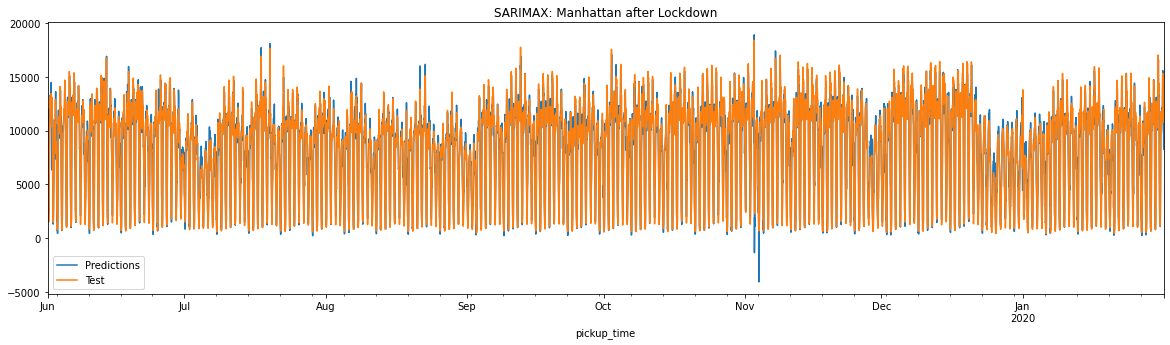

In [44]:
fig, ax = plt.subplots(figsize=(20, 5))
predictions_june.plot(ax=ax)
#man_precovid_test.plot(ax=ax)
man_precovid_train.plot(ax=ax)
plt.legend(['Predictions', 'Test', 'Train'])
plt.title('SARIMAX: Manhattan after Lockdown')

In [ ]:
# evaluate the model on the training data
train_sarimax_rmse = np.sqrt(np.mean(sarimax_1.resid**2))  # check the RMSE scores
placeholder_man['sarimax_1'] = train_sarimax_rmse

placeholder_man

Our SARIMAX model with two exogenous variables had the lowest RMSE score. On June 8th, Phase One had started and you can see how the demand for yellow cabs started to increase and continue to increase. Phase two started on June 22nd. So the trend seems to be increaasing as the lockdown started to loosen up. The only downside of this model is that the start of the ease on NYC lockdown was not considered. So you can see my predictions just continue off from the way my trainset was reflected upon and missing the abnormality. 

# FACEBOOK PROPHET

In [52]:
fb_df = man_precovid_df.reset_index()
fb_df.rename(columns={'pickup_time': 'ds', 'count': 'y'}, inplace=True)
fb_df

,ds,y
0,2019-06-01 00:00:00,10744
1,2019-06-01 01:00:00,8371
2,2019-06-01 02:00:00,6212
3,2019-06-01 03:00:00,4319
4,2019-06-01 04:00:00,2921
...,...,...
7075,2020-03-21 19:00:00,709
7076,2020-03-21 20:00:00,539
7077,2020-03-21 21:00:00,386
7078,2020-03-21 22:00:00,340


In [53]:
from fbprophet import Prophet

model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode = 'additive',)
model.fit(fb_df)

ERROR - Importing plotly failed. Interactive plots will not work.


### Predicting until 4/20/2020

In [55]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
output = forecast.tail(366)
output

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6744,2020-03-08 00:00:00,5997.509262,592.051578,6500.381928,5997.509262,5997.509262,-2472.895173,-2472.895173,-2472.895173,-2103.536079,-2103.536079,-2103.536079,-369.359093,-369.359093,-369.359093,0.0,0.0,0.0,3524.614090
6745,2020-03-08 01:00:00,5994.797153,-1003.960820,4782.387066,5994.797153,5994.797153,-4136.441878,-4136.441878,-4136.441878,-3692.505465,-3692.505465,-3692.505465,-443.936413,-443.936413,-443.936413,0.0,0.0,0.0,1858.355275
6746,2020-03-08 02:00:00,5992.085044,-2683.217219,2833.856462,5992.085044,5992.085044,-5817.494058,-5817.494058,-5817.494058,-5297.526987,-5297.526987,-5297.526987,-519.967071,-519.967071,-519.967071,0.0,0.0,0.0,174.590985
6747,2020-03-08 03:00:00,5989.372934,-4029.479898,1816.169998,5989.372934,5989.372934,-7152.264743,-7152.264743,-7152.264743,-6555.201776,-6555.201776,-6555.201776,-597.062967,-597.062967,-597.062967,0.0,0.0,0.0,-1162.891809
6748,2020-03-08 04:00:00,5986.660825,-4166.694254,1421.908975,5986.660825,5986.660825,-7553.642242,-7553.642242,-7553.642242,-6878.832542,-6878.832542,-6878.832542,-674.809700,-674.809700,-674.809700,0.0,0.0,0.0,-1566.981417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7105,2020-04-16 23:00:00,3396.596489,744.468638,6606.855213,2896.601735,3939.127659,323.056202,323.056202,323.056202,-546.979921,-546.979921,-546.979921,870.036123,870.036123,870.036123,0.0,0.0,0.0,3719.652691
7106,2020-04-17 23:00:00,3331.505867,507.989589,6194.979316,2795.228005,3909.129470,48.619235,48.619235,48.619235,-546.979921,-546.979921,-546.979921,595.599156,595.599156,595.599156,0.0,0.0,0.0,3380.125102
7107,2020-04-18 23:00:00,3266.415245,-367.578843,5367.726506,2689.100079,3878.476277,-843.573675,-843.573675,-843.573675,-546.979921,-546.979921,-546.979921,-296.593754,-296.593754,-296.593754,0.0,0.0,0.0,2422.841570
7108,2020-04-19 23:00:00,3201.324623,-2019.303719,4058.891780,2593.362157,3844.727646,-2218.873701,-2218.873701,-2218.873701,-546.979921,-546.979921,-546.979921,-1671.893779,-1671.893779,-1671.893779,0.0,0.0,0.0,982.450922


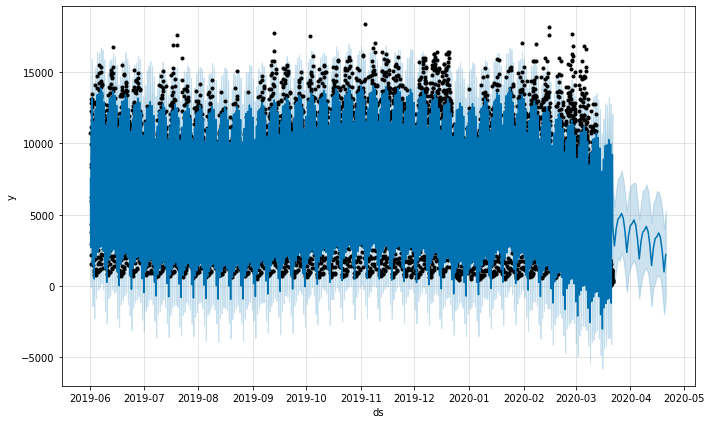

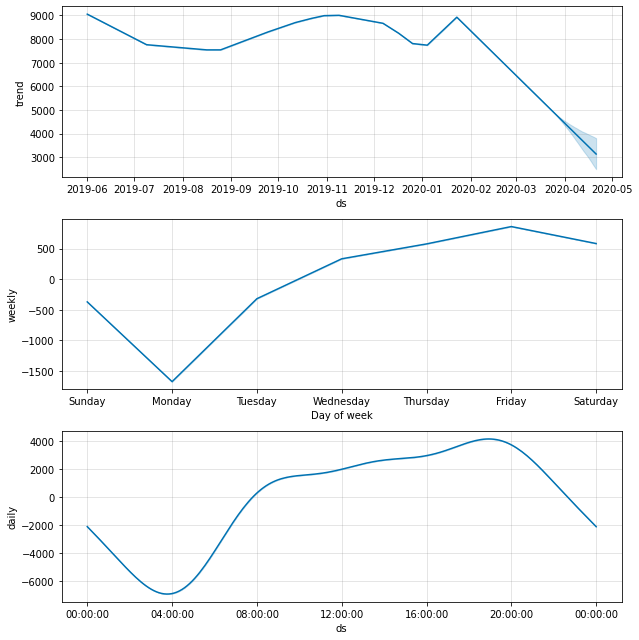

In [57]:
# Plot the fit to past data and future forecast.
fig1 = model.plot(forecast)
 
# Plot breakdown of components.
fig2 = model.plot_components(forecast) 
plt.show()

In [58]:
se = np.square(forecast.loc[:, 'yhat'] - fb_df['y'])
mse = np.mean(se)
rmse = np.sqrt(mse)
print('MSE:', mse, 'rmse:', rmse)
placeholder_man['fbprophet'] = rmse
placeholder_man

MSE: 4927600.496368845 rmse: 2219.8199243111694


{'naive_forecast_baseline': 6024.486544995626,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2036.5722509949862,
 'rmse_holt_winter': 987.1542055166258,
 'arima_1': 1153.263898456226,
 'arima_2': 2654.5283587292543,
 'sarima_1': 806.6490746187087,
 'fbprophet': 2219.8199243111694}

In [59]:
Our best model ended up being sarima model. 

SyntaxError: invalid syntax (<ipython-input-59-7f3446d7d396>, line 1)